# 1. 라이브러리 설치

In [2]:
!python -m pip install statsmodels
!python -m pip install seaborn
!python -m pip install requests
!python -m pip install bs4
!python -m pip install prettytable
!python -m pip install pandas
!python -m pip install scikit-learn
!python -m pip install numpy
!python -m pip install tensorflow
!python -m pip install matplotlib


# 2. Import 라이브러리

In [3]:
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

import statsmodels.api as sm


# 3. 함수 및 경로

In [4]:
def shuffle_list(input_list):
    """
    입력받은 리스트의 요소들을 무작위로 섞어 새 리스트를 반환
    
    Parameters:
    - input_list (리스트): 섞기 전의 원본 리스트
    
    Returns:
    - List: 원본 리스트의 요소들이 무작위로 섞인 새로운 리스트
    """
    shuffled_list = input_list[:]  # 원본 리스트의 복사본을 생성
    random.shuffle(shuffled_list)  # 복사본 리스트를 무작위로 섞음
    return shuffled_list

def get_mse(list1, list2):
    """
    두 리스트 간의 평균 제곱 오차(MSE)를 계산

    Parameters:
    - list1 (float 리스트): 실제 값들을 포함한 첫 번째 리스트
    - list2 (float 리스트): 예측 값들을 포함한 두 번째 리스트

    Returns:
    - float: 계산된 평균 제곱 오차(MSE) 값
    """
    if len(list1) != len(list2):
        raise ValueError("두 리스트의 길이는 동일해야 합니다.")
    
    mse = sum((x - y) ** 2 for x, y in zip(list1, list2)) / len(list1)
    return mse

def get_mae(list1, list2):
    """
    두 리스트 간의 평균 절대 오차(MAE)를 계산

    인자:
    - list1 (float 리스트): 실제 값들을 포함한 첫 번째 리스트
    - list2 (float 리스트): 예측 값들을 포함한 두 번째 리스트

    반환값:
    - float: 계산된 평균 절대 오차(MAE) 값
    """
    if len(list1) != len(list2):
        raise ValueError("두 리스트의 길이는 동일해야 합니다.")
    
    mae = sum(abs(x - y) for x, y in zip(list1, list2)) / len(list1)
    return mae

def reading_file(file_path):
    """
    CSV 파일 리딩 -> DataFrame으로 변환

    Parameters:
    - value: 날짜를 나타내는 String변수
    
    Returns:
    - 변환된 String 날찌 변수 (YYYY-MM 형식)
    """

    # 시도할 인코딩 목록
    encodings = ['utf-8', 'cp949', 'ISO-8859-1', 'cp1252']  
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            return df  # 데이터프레임 반환 또는 데이터프레임 처리
        except Exception as e:
            pass
    return None

def convert_date(date_str):
    """
    - 모든 DATE string -> YYYY-MM 형식으로 변환, 
    - 통계청의 자료를 활용했기 때문에, 해당 형식에 대해 변환이 필요함.
    
    Parameters:
    - String: 날짜 정보를 담고 있음 
    
    Returns:
    - String (YYYY-MM 형식의 날짜 정보)
    """

    if len(date_str) == 7 and date_str[4] == '-': # 이미 'YYYY-MM'형식을 만족
        return date_str.strip()
    else: # 'YYYY-MM'형식을 만족하지 못함
        parts = date_str.strip().split('-')
        month_to_num = { # 월 약어를 월 번호로 변환하는 딕셔너리
            'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
            'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
        }
        
        # 형식을 확인하고 그에 따라 조정
        if len(parts[0]) == 3:  # 첫 부분이 월 약어인 경우, 예: 'Mar-00'
            month = month_to_num[parts[0]]
            year = '20' + parts[1] if parts[1] < '50' else '19' + parts[1]
        else:  # 첫 부분이 연도인 경우, 예: '2000-03'
            month = month_to_num[parts[1]]
            year = parts[0]
            year = '20' + parts[0] if parts[0] < '50' else '19' + parts[0]

        return f'{year}-{month}'

def calculate_std(values):
    """
    주어진 값들의 리스트에서 표준편차를 계산하는 함수.

    Parameters:
    - List: 표준편차를 계산할 값들의 리스트.

    Returns:
    - 표준편차(float).
    """
    # NumPy의 std 함수를 사용하여 표준편차 계산
    std_value = np.std(values)
    return std_value


In [5]:
PATH_DATA_Y = 'data_y/Disease.csv'
ATTR_Y = 'Disease'

# 4. 데이터 수집

### 4.1. Input 데이터(X) 가져오기 - 'data_x'폴더 참조

In [6]:
entries = os.listdir('data_x')  # data_x 폴더(입력변수) 내의 파일 목록
exception_headers = {'지역번호', '일시', '지역명', '최대풍속지점', '지점', '최대순간풍속지점'}  # 제외할 열 이름
data_in = {}  # 입력 변수들을 저장

# 폴더 내의 모든 파일에 대해 반복
for file_name in entries:
    if file_name.split('.')[1] == 'csv': # CSV 파일만 처리
        # 속성 추출
        attr = file_name.split('.')[0]
        data_in[attr] = {}

        # 입력변수 파일 -> DataFrame
        df = reading_file(f'data_x/{file_name}')  
        
        # DataFrame의 모든 행에 대해 반복
        for i in range(len(df)):
            # 날짜 정보 추출
            date_key = convert_date(df['일시'][i].strip(' '))  
            data_in[attr][date_key] = []

            # 제외할 열을 제외한 데이터 수집
            for key in df.keys():
                if key not in exception_headers:
                    value = 0 if df[key][i] == None else df[key][i]
                    data_in[attr][date_key].append(value)


### 4.2. Output 데이터(Y) 가져오기 - 'data_y'폴더 참조

In [7]:
df = reading_file(PATH_DATA_Y)
exception_headers = {'월별', '시점'}

# 날씨에 영향을 받을 가능성이 높은 감염병 리스트
header_list = ["말라리아","뎅기열","쯔쯔가무시증","라임병","리슈마니아증","서부나일열","치쿤구니야열","지카바이러스감염증"]
data_out = {ATTR_Y: {}}  # 결과 변수들을 저장

for i in range(len(df)):
    try:
        yy = int(df['시점'][i])
        mm = int(df['월별'][i].strip(' ').split('월')[0])
        date_v = str(yy * 100 + mm)
        date_key = f'{date_v[:4:]}-{date_v[4::]}'
        data_out[ATTR_Y][date_key] = [0.0]
        for h in header_list:
            if h in exception_headers:
                continue
            try:
                data_out[ATTR_Y][date_key][0] += float(df[h][i])
            except:
                pass
    except Exception as e:
        pass


### 4.3. X -> Y 월별 데이터 수집

In [8]:
x_set, y_set = [], [] # 입력변수, 결과변수
for yy in range(1997, 2023): # Years 1997 ~ 2022
    for mm in range(1,13):
        # 날짜 정보 추출
        mm = f'{100+mm}'[1::]
        date_key = f'{yy}-{mm}'

        # 데이터 추가
        try:
            # 결과 변수 추출(Y)
            y = data_out[ATTR_Y][date_key]
            y_set.append(y)

            # 입력 변수 추출(X)
            nested_x = [data_in[attr][date_key] for attr in data_in]
            x = [item for sublist in nested_x for item in sublist]
            x_set.append(x)
            
        except:
            pass



# 5. 모델 구성 및 테스트

### 5.1. 모델 구성 함수

In [9]:
# make_model1: 기본 모델
def make_model1(x, y):
    # 데이터를 NumPy 배열로 변환하고 학습/테스트 세트로 분할
    np_x, np_y = np.array(x), np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.2, random_state=42)

    # 신경망 모델 구성: 1개의 은닉층과 드롭아웃 적용
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(np_y.shape[1], activation='linear')
    ])

    # 모델 컴파일: 옵티마이저, 손실 함수, 평가 지표 설정
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    # 모델 학습
    model.fit(x_train, y_train, epochs=100)
    return model, x_test, y_test
    
# make_model2: 은닉층 추가 및 검증 데이터 사용
def make_model2(x, y):
    np_x, np_y = np.array(x), np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.2, random_state=42)

    # 추가된 은닉층과 드롭아웃 적용
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),  # 추가된 은닉층
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(np_y.shape[1], activation='linear')
    ])

    # 검증 데이터(validation_split) 사용하여 학습
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(x_train, y_train, validation_split=0.2, epochs=100)
    return model, x_test, y_test

# make_model3: 더 많은 은닉층 추가 및 검증 데이터 분할 비율 변경
def make_model3(x, y):
    np_x, np_y = np.array(x), np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.2, random_state=42)

    # 더 많은 은닉층 추가
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),  # 추가된 은닉층
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(np_y.shape[1], activation='linear')
    ])

    # 검증 데이터 분할 비율 변경: 0.25로 증가
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(x_train, y_train, validation_split=0.25, epochs=100)
    return model, x_test, y_test

# make_model4: 데이터 전처리(표준화) 추가
def make_model4(x, y):
    np_x, np_y = np.array(x), np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.2, random_state=42)

    # 데이터 표준화 적용
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(np_y.shape[1], activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(x_train_scaled, y_train, validation_split=0.2, epochs=100)
    return model, x_test, y_test

# make_model5: 타겟 변수 무작위로 섞기
def make_model5(x, y):
    # 타겟 변수를 무작위로 섞음
    y = shuffle_list(y)
    np_x, np_y = np.array(x), np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(np_x, np_y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(np_y.shape[1], activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(x_train_scaled, y_train, validation_split=0.2, epochs=100)
    return model, x_test, y_test


### 5.2. 모델 테스트

In [10]:
class Evaluation:
    def __init__(self, predict, actual):
        self.predict = predict
        self.actual = actual
        self.mse = get_mse(predict, actual)
        self.mae = get_mae(predict, actual)

# 최적 모델 함수, 최적 MAE
funcs = [make_model1, make_model2, make_model3, make_model4, make_model5]
models = [func(x_set, y_set) for func in funcs]

opt_model, opt_mse = None, float('inf')
model_evals = []

for i, data in enumerate(models):
    model, x_test, y_test = data
    predict = [y[0] for y in model.predict(x_test)]
    actual = [y[0] for y in y_test]
    eval = Evaluation(predict, actual)
    model_evals.append(eval)




Epoch 1/100


6/6 [==============================] - 1s 2ms/step - loss: 78576.8672 - mae: 199.3658
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 66799.2500 - mae: 172.7739
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 56831.8633 - mae: 156.5840
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 48194.8789 - mae: 147.3458
Epoch 5/100
6/6 [==============================] - 0s 1ms/step - loss: 44923.2734 - mae: 149.6660
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 41421.4648 - mae: 146.1342
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 39827.4961 - mae: 146.8323
Epoch 8/100
6/6 [==============================] - 0s 971us/step - loss: 40082.1328 - mae: 148.7166
Epoch 9/100
6/6 [==============================] - 0s 1ms/step - loss: 37589.8711 - mae: 148.0981
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 38278.5664 - mae: 147.4855
Epoch 11/100


# 6. 모델 평가 결과 출력 및 시각화.

### 6.1. 예측값 vs 실제값

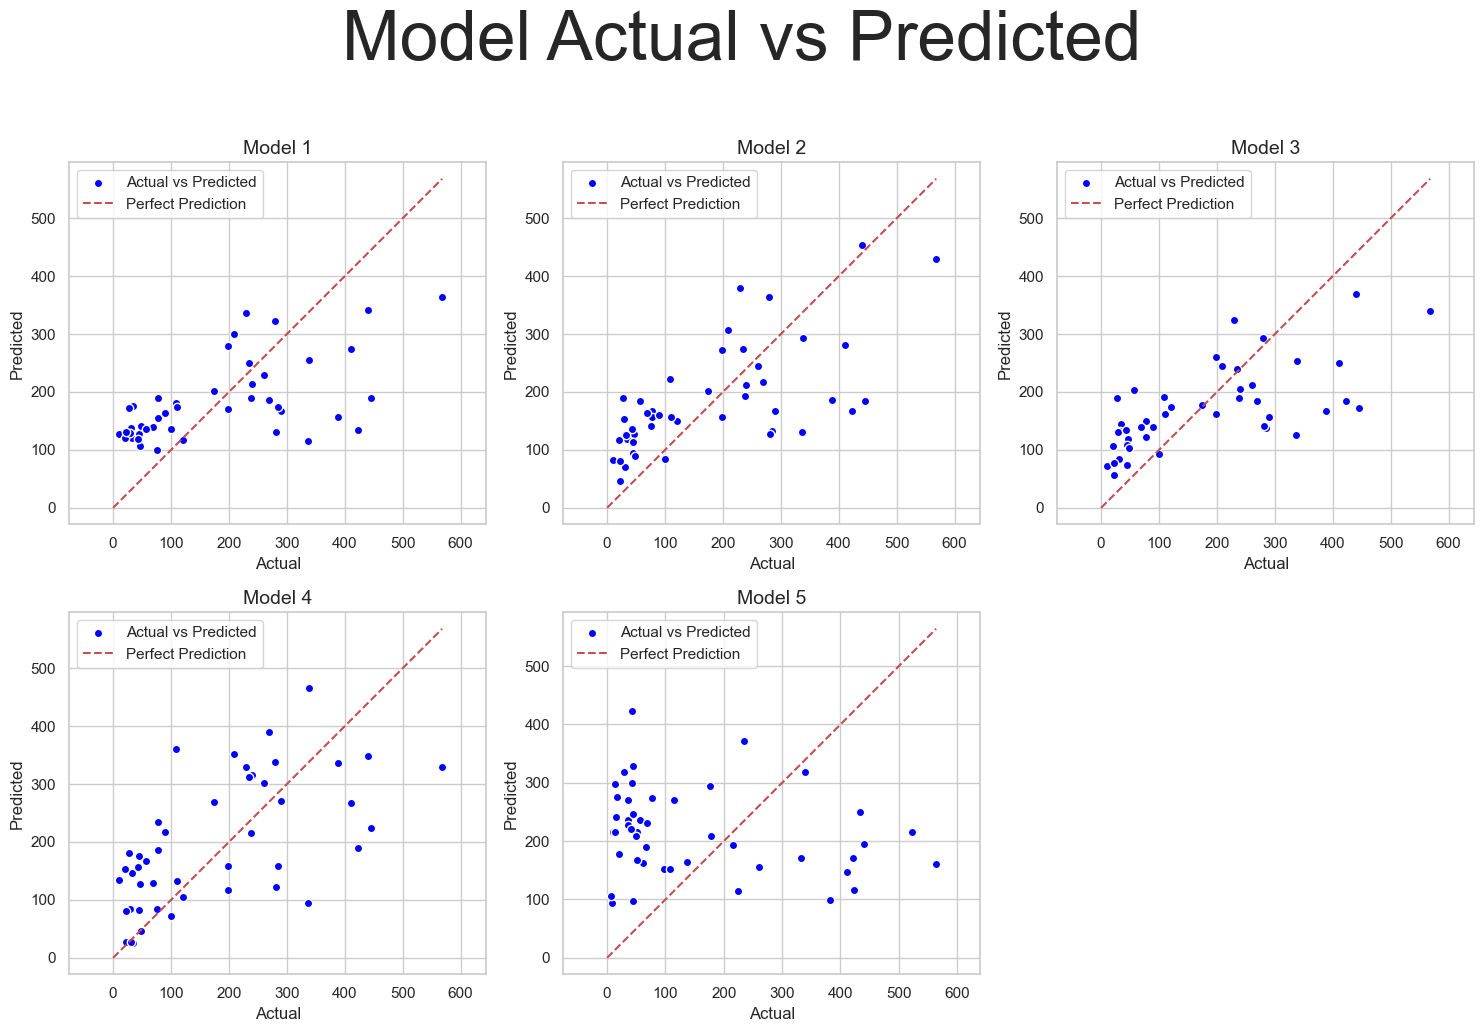

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set(style='whitegrid')

# 모델 개수에 따른 행과 열 계산
n_models = len(model_evals)
n_cols = 3
n_rows = n_models // n_cols + (n_models % n_cols > 0)

# 전체 figure 크기 설정
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
fig.suptitle('Model Actual vs Predicted', fontsize=50, y=1.03)

# 모든 subplot에 대해 반복
for index, eval in enumerate(model_evals):
    row, col = divmod(index, n_cols)
    ax = axes[row][col] if n_rows > 1 else axes[col]
    
    # 실제 값 대 예측 값을 파란색 사각형으로 표시
    ax.scatter(eval.actual, eval.predict, color='blue', edgecolor='w', label='Actual vs Predicted')
    top = max(max(eval.actual), max(eval.predict))
    
    # 완벽한 예측을 나타내는 대각선 추가
    ax.plot([0, top], [0, top], 'r--', label='Perfect Prediction')
    
    ax.set_xlabel('Actual', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(f'Model {index + 1}', fontsize=14)
    ax.grid(True)
    ax.axis('equal')
    ax.legend()

# 남는 subplot 숨기기
for j in range(index + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


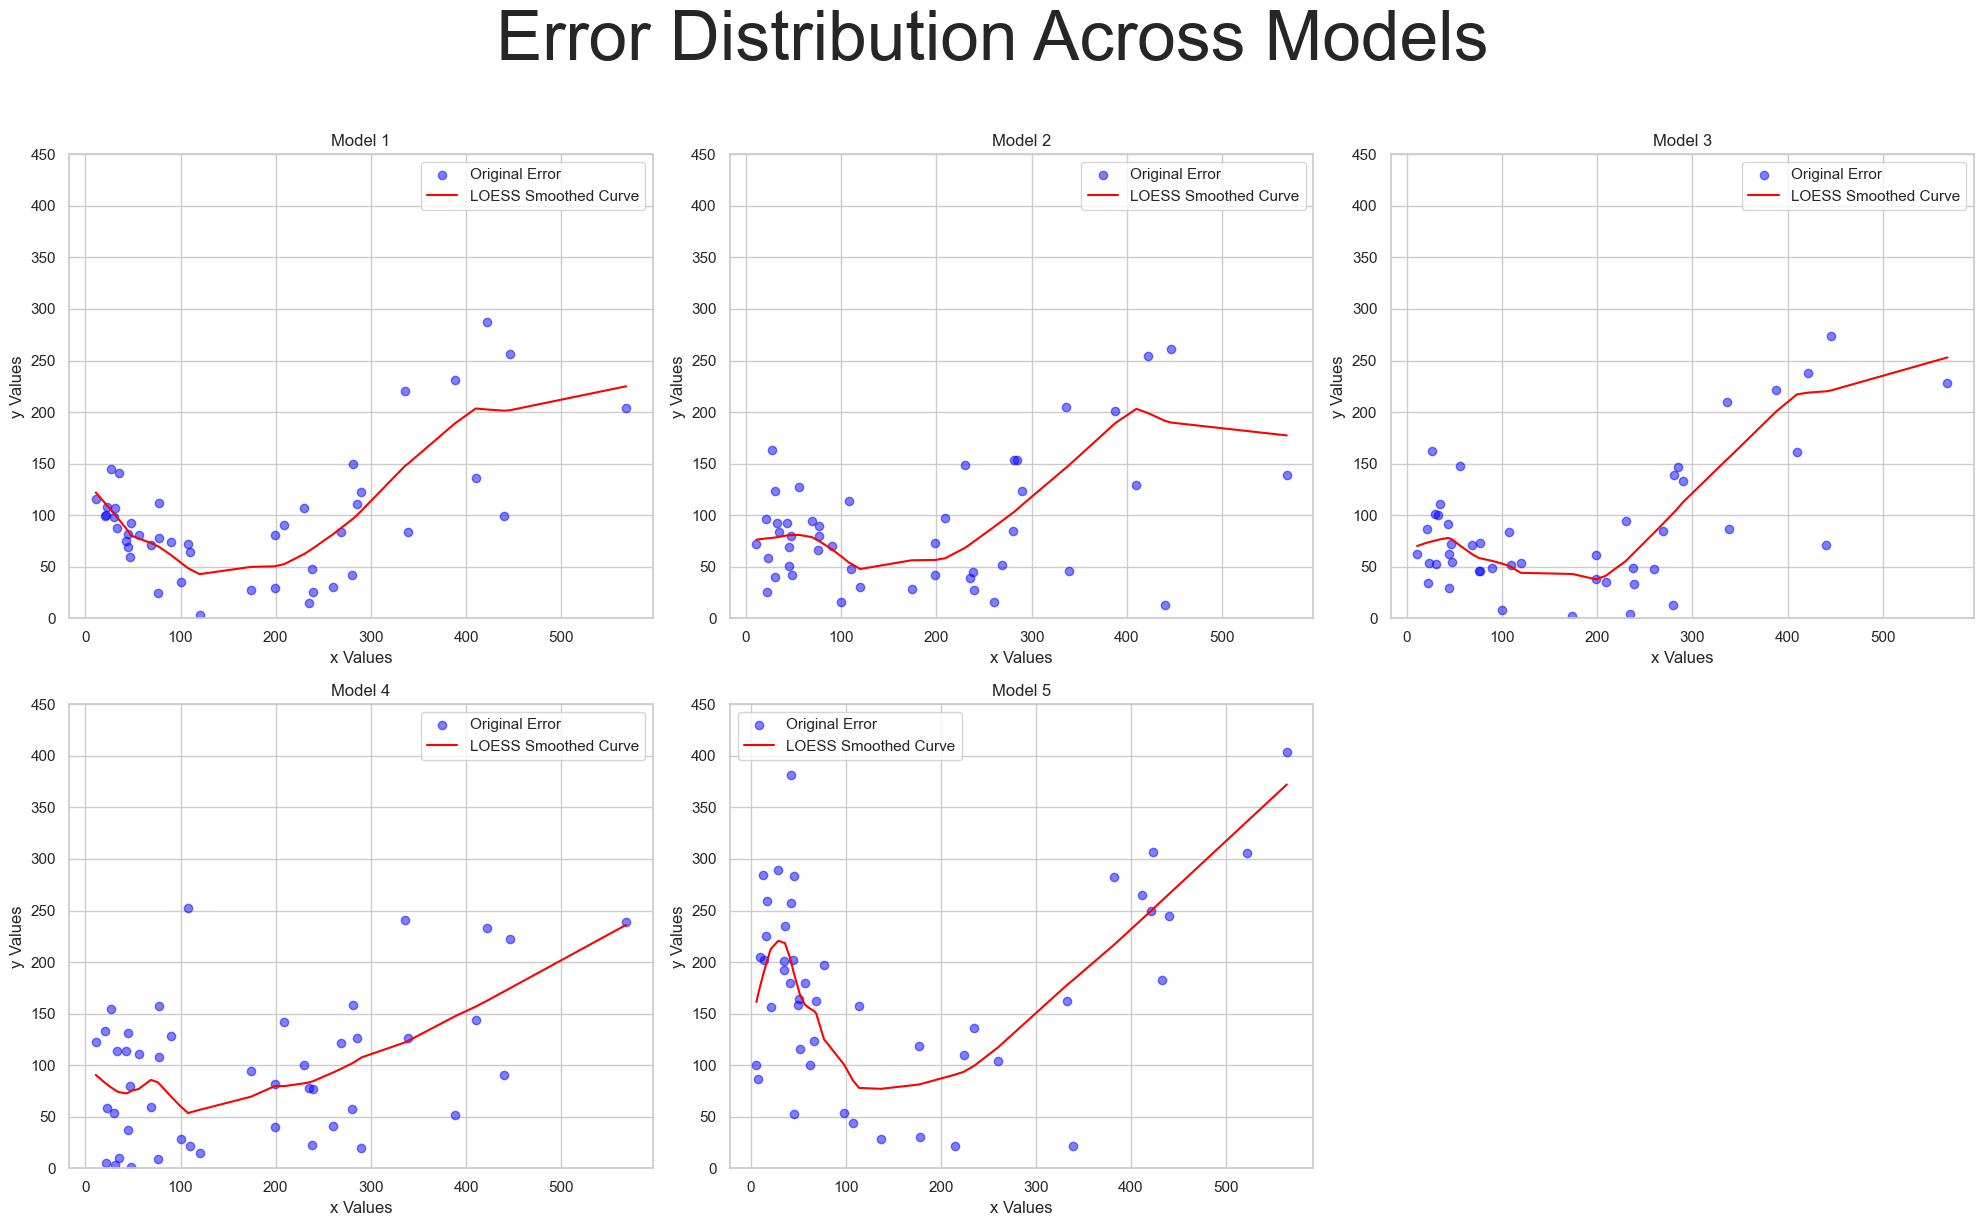

In [18]:
def plot_prediction_error(actual, predict, subplot_position):
    # 오차 계산 및 정렬
    x_values = np.array(actual)
    y_values = np.abs(np.array(predict) - np.array(actual))
    sort_index = np.argsort(x_values)
    x_values_sorted = x_values[sort_index]
    y_values_sorted = y_values[sort_index]
    
    # LOESS 스무딩
    lowess = sm.nonparametric.lowess(y_values_sorted, x_values_sorted, frac=0.4)
    
    # Subplot 설정
    plt.subplot(2, 3, subplot_position)
    plt.title(f'Model {subplot_position}')
    plt.scatter(x_values, y_values, color='blue', alpha=0.5, label='Original Error')
    plt.plot(lowess[:, 0], lowess[:, 1], color='red', label='LOESS Smoothed Curve')
    plt.xlabel('x Values')
    plt.ylabel('y Values')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 450)

# 전체 그래프 출력 설정
plt.figure(figsize=(20, 12))
plt.suptitle('Error Distribution Across Models', fontsize=50, y=1.02)

# model_evals의 각 항목에 대해 함수 실행
for index, eval in enumerate(model_evals, start=1):
    plot_prediction_error(eval.actual, eval.predict, index)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### 6.2 .MSE, MAE, 표준 MAE

In [13]:
import matplotlib.pyplot as plt

evals = {}
std = calculate_std(y_set)
for index, eval in enumerate(model_evals, start=1):
    evals[f'Model{index}'] = {
        'mse':eval.mse,
        'mae':eval.mae, 
        'mae_standardized': eval.mae / std
    }

df = pd.DataFrame(evals)


                 mse         mae  mae_standardized
Model1  13226.506889   97.295398          0.529264
Model2  11663.786296   90.298248          0.491201
Model3  11995.638773   88.572972          0.481816
Model4  13806.994739   95.951726          0.521954
Model5  40559.822409  178.702209          0.972097


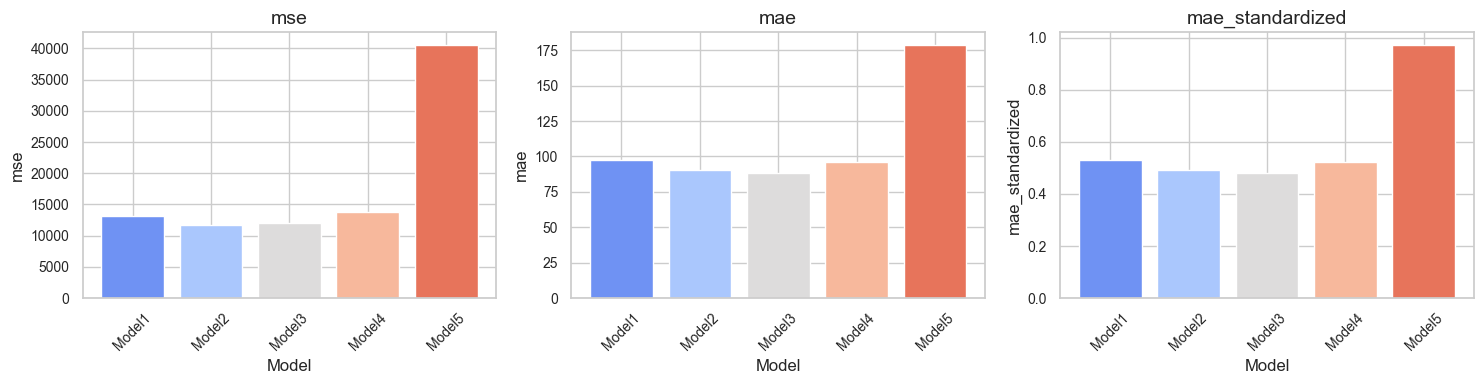

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set(style="whitegrid")

# evals 딕셔너리에서 DataFrame 생성
df = pd.DataFrame.from_dict(evals, orient='index')

# 그래프의 총 개수 및 행, 열 계산
n_metrics = len(df.columns)
n_rows = n_metrics // 3 + (1 if n_metrics % 3 else 0)  # 총 필요한 행의 수
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))  # subplots으로 여러 그래프 그리드 생성

# 각 평가 지표별로 그래프 생성
for i, metric in enumerate(df.columns):
    row, col = divmod(i, 3)
    ax = axes[row, col] if n_rows > 1 else axes[col]  # 현재 subplot의 축 선택
    ax.bar(df.index, df[metric], color=sns.color_palette("coolwarm", len(df)))  # 막대 그래프 생성
    ax.set_title(f'{metric}', fontsize=14)  # 제목 설정
    ax.set_xlabel('Model', fontsize=12)  # x축 라벨 설정
    ax.set_ylabel(metric, fontsize=12)  # y축 라벨 설정
    ax.tick_params(axis='x', rotation=45, labelsize=10)  # x축 라벨 설정
    ax.tick_params(axis='y', labelsize=10)  # y축 라벨 설정

# 빈 subplot의 축 숨기기
for j in range(i + 1, n_rows * 3):
    row, col = divmod(j, 3)
    axes[row, col].set_visible(False) if n_rows > 1 else axes[col].set_visible(False)

print(df)
plt.tight_layout()
plt.show()
